In [ ]:
#| default_exp hooks

In [ ]:
#| export
import random, math, torch, numpy as np, matplotlib.pyplot as plt
from tinyai.learner import *
from tinyai.model import *
import fastcore.all as fc
from functools import partial

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
# |export
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [5]:
import tiktoken
import os

enc = tiktoken.get_encoding("gpt2")

def get_tokens(input_file):
    with open(input_file) as f:
        text = f.read()
    tokens = enc.encode(text)
    return tokens

cwd = os.getcwd()
input_file = f"{cwd}/fast-nanogpt/input.txt"
tokens = get_tokens(input_file)[:10000]
train, valid = tokens[:int(len(tokens)*0.8)], tokens[int(len(tokens)*0.8):]

In [6]:
# | export
class DataSet:
    def __init__(self, tokens, T=32):
        self.tokens = tokens
        self.T = T

    def __len__(self):
        return (len(self.tokens) - 1) // self.T

    def __getitem__(self, i):
        x = self.tokens[i * self.T : (i + 1) * self.T]
        y = self.tokens[i * self.T + 1 : (i + 1) * self.T + 1]
        return x, y

In [7]:
tds = DataSet(torch.tensor(train))
# vds = DataSet(torch.tensor(valid))
dls = DataLoaders.from_dd([tds, None], batch_size=4)
# dls = DataLoaders.from_dd([tds, vds], batch_size=4)

In [8]:
x, y = next(iter(dls.train))
x[0], y[0]

(tensor([ 5962, 22307,    25,   198,  8421,   356,  5120,   597,  2252,    11,
          3285,   502,  2740,    13,   198,   198,  3237,    25,   198,  5248,
           461,    11,  2740,    13,   198,   198,  5962, 22307,    25,   198,
          1639,   389]),
 tensor([22307,    25,   198,  8421,   356,  5120,   597,  2252,    11,  3285,
           502,  2740,    13,   198,   198,  3237,    25,   198,  5248,   461,
            11,  2740,    13,   198,   198,  5962, 22307,    25,   198,  1639,
           389,   477]))

loss,epoch,train
7.455,0,train


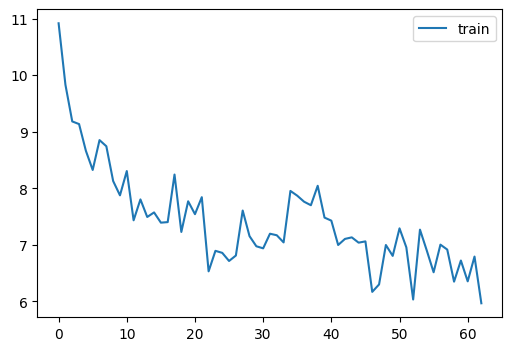

In [23]:
model = get_model()
cbs = [TrainCB(), DeviceCB(), MetricsCB(), ProgressCB(plot=True)]
lrn = Learner(model, dls=dls, opt_func=optim.AdamW, cbs=cbs, lr=3e-4)
lrn.fit(1, valid=False)

In [ ]:
cbs[-1].val_losses
del model

## How to evaluate the training process
We can evaluate the training process by evaluating the activations. The activations of each layer should roughly have mean of 0 and standard deviation of 1.


In [9]:
# | export
class Hook:
    def __init__(self, m, f):
        self.hook = m.register_forward_hook(partial(f, self))
        # print(self.hook, m)

    def remove(self):
        self.hook.remove()

    def __del__(self):
        self.remove()

In [10]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, "stats"):
        hook.stats = ([], [])  # mean, std of activations
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [11]:
#| export
class Hooks(list):
    def __init__(self, ms, f):
        super().__init__([Hook(m, f) for m in ms])

    def __enter__(self, *args):
        return self

    def __exit__(self, *args):
        self.remove()

    def __del__(self):
        self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)

    def remove(self):
        for h in self:
            h.remove()

In [12]:
# | export
class HooksCallback(Callback):
    def __init__(
        self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None
    ):
        fc.store_attr()
        super().__init__()

    def before_fit(self, learn):
        if self.mods:
            mods = self.mods
        else:
            mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training):
            self.hookfunc(*args, **kwargs)

    def after_fit(self, learn):
        self.hooks.remove()

    def __iter__(self):
        return iter(self.hooks)

    def __len__(self):
        return len(self.hooks)

In [13]:
# | export
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, "stats"):
        hook.stats = ([], [], [])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40, 0, 10))

In [21]:
def fit(model, epochs=1, xtra_cbs=None):
    lrn = Learner(model, dls=dls, opt_func=optim.AdamW, cbs=cbs + fc.L(xtra_cbs), lr=3e-4)
    lrn.fit(epochs, valid=False)
    return lrn

In [ ]:
model = get_model()

In [ ]:
set_seed(1)
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(Block))
lrn = fit(model, xtra_cbs=[hc])

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for h in hc:
    for i in 0, 1:
        axs[i].plot(h.stats[i])
axs[0].set_title("Mean")
axs[1].set_title("Std")
plt.legend(range(4))

In [30]:
# | export
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0] / h1.sum(0)

In [27]:
#| export
def get_hist(h):
    return torch.stack(h.stats[2]).t().float().log1p()

In [14]:
#| export
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

In [15]:
#| export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig,ax

In [16]:
#| export
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

In [ ]:
fig, axes = get_grid(len(hc), figsize=(11, 5))
for ax, h in zip(axes.flat, hc):
    show_image(get_hist(h), ax, origin="lower")

In [17]:
# |export
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop):
        super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11, 5)):
        fig, axes = get_grid(len(self), figsize=figsize)
        for ax, h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin="lower")

    def dead_chart(self, figsize=(11, 5)):
        fig, axes = get_grid(len(self), figsize=figsize)
        for ax, h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0, 1)

    def plot_stats(self, figsize=(10, 4)):
        fig, axs = plt.subplots(1, 2, figsize=figsize)
        for h in self:
            for i in 0, 1:
                axs[i].plot(h.stats[i])
        axs[0].set_title("Means")
        axs[1].set_title("Stdevs")
        plt.legend(fc.L.range(self))

In [19]:
stats = ActivationStats(fc.risinstance(Block))

loss,epoch,train
7.488,0,train


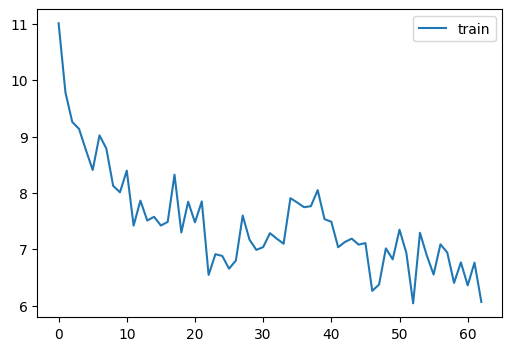

In [24]:
set_seed(1)
model = get_model()
lrn = fit(model, xtra_cbs=[stats])

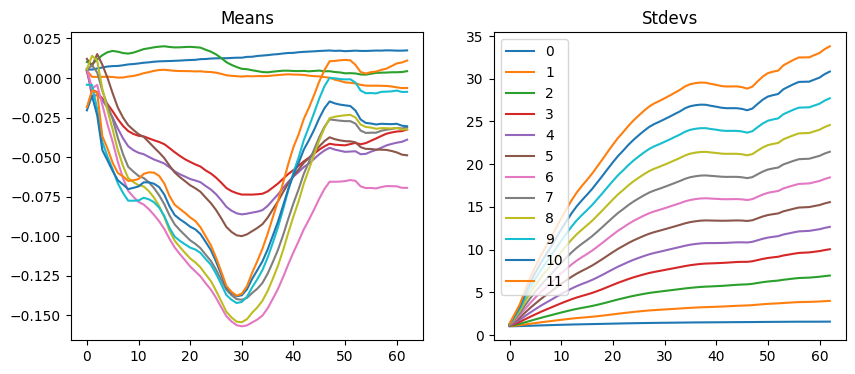

In [25]:
stats.plot_stats()

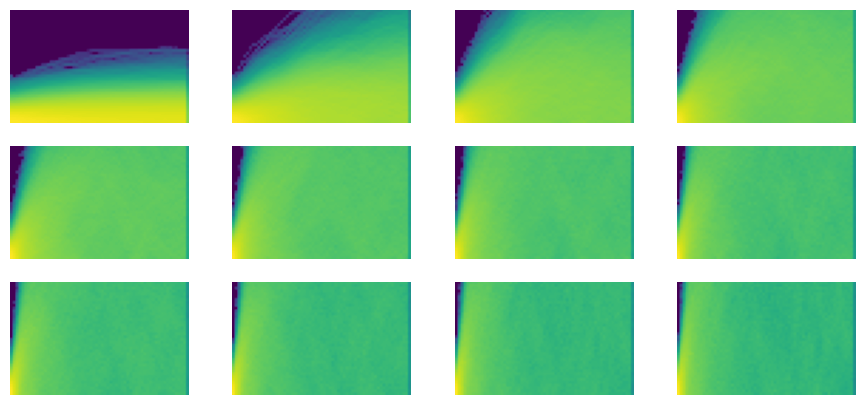

In [28]:
stats.color_dim()

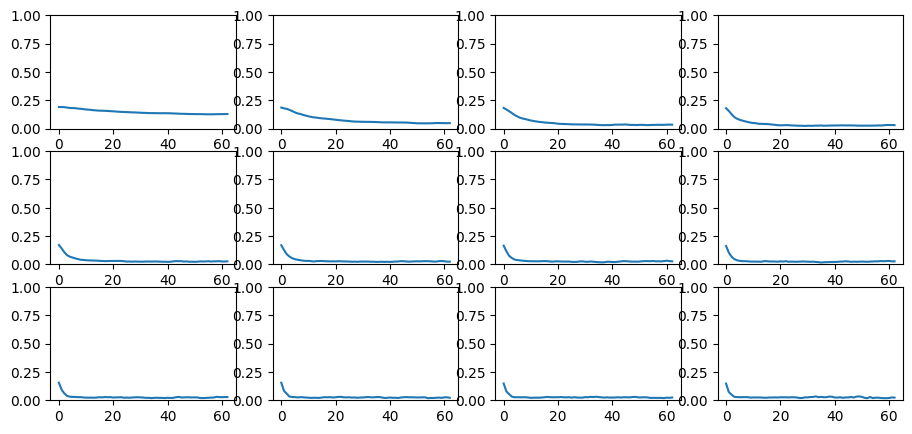

In [31]:
stats.dead_chart()